**Using GAN to upscale images from 128x128 to 256x256**

references : 

https://www.tensorflow.org/tutorials/generative/pix2pix

https://arxiv.org/abs/1609.04802

**IMPORTING LIBRARIES AND PACKAGES**

In [39]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
import datetime
from IPython.display import clear_output
import time

weights_file_index = "2023-06-03_13"
load_weights = False

**LOADING DATASET**

* using 256x256 images from MSCOCO dataset
* X is array containing input images generated by resizing original images to 128x128 size
* Y is array containing original images of 256x256 size
* Only 1000 images are used out of 80K images for faster computation

In [19]:
# secondary function

def parse(img, chunk, with_map=False):
    img_new = np.array(img)
    img_width = img_new.shape[0]
    img_height = img_new.shape[1]
    #print("shape", img_width, img_height)
    rows = img_height/chunk
    row_remainder = img_height%chunk
    columns = img_width/chunk
    column_remainder = img_width%chunk
    #print("remainders", row_remainder, column_remainder)
    rows, columns = int(rows), int(columns)
    start_r, start_c = int(row_remainder//2), int(column_remainder//2)
    #print("start position", start_r, start_c)

    img_new = [img_new[(start_c+j*chunk):(start_c+j*chunk)+chunk, 
                       (start_r+i*chunk):(start_r+i*chunk)+chunk] for i in range(rows) for j in range(columns)]
    if with_map:
        return({"img":img_new, "map":(rows,columns)})
    return img_new

def rebuild_img(v0chunks, img_map):
    chunks = np.array(v0chunks)
    face = chunks.shape[-2]
    temp = np.zeros((face*img_map[-1], face*img_map[0],3))
    for y in range(img_map[-1]):
        for x in range(img_map[0]):
            temp[face*y:face*(y+1), face*x:face*(x+1)] = chunks[x*img_map[0]+y]
    temp = np.uint8(temp)
    assert (temp.shape[:-1] == np.array(img_map)*face).all
    return temp

In [20]:
X = []
Y = []

batch_size = 0
junk = 0
dirname = r"C:\Users\common\source\Jupyter\GAN based image upscaling\mscoco\mscoco_resized\val2017"

weights_folder = "weights/"

try:
  os.mkdir(weights_folder)
except FileExistsError:
  pass

for filename in tqdm(os.listdir(dirname)):
    im  = Image.open(os.path.join(dirname, filename))
    
    if any([shape < 256 for shape in np.array(im).shape[:2]]):
        junk += 1
        continue
    im = parse(im, 256)
    for chunk in im:
        image = Image.fromarray(chunk)
        image = image.convert("RGB")
        image = image.resize((256,256))
        #if np.array(chunk).shape == (256,256):
        #    image = Image.fromarray(chunk)
        #    image = image.convert("RGB")
        #    chunk = image.resize((256,256))
        assert np.array(image).shape == (256,256,3)
        #temp = image
        Y.append(np.array(image))
        
        batch_size += 1
        image = image.resize((128,128))
        X.append(np.array(image))
        #**********************************
        #plt.figure(figsize = (20,20))
        #plt.axis('off')
        #plt.subplot(1,3,1)
        #plt.imshow(temp)
        #plt.subplot(1,3,2)
        #plt.imshow(image)
        #assert 1==0
        #**********************************
    #if batch_size > 50: break

        
print("Batch size: ", batch_size)
print("waste: ", junk)

X = np.array(X, dtype = 'float32')
Y = np.array(Y, dtype = 'float32')

X = (X/127.5)-1
Y = (Y/127.5)-1

X_train = X[:-10].reshape(-1,1,128,128,3)
Y_train = Y[:-10].reshape(-1,1,256,256,3)

X_test = X[-10:].reshape(-1,1,128,128,3)
Y_test = Y[-10:].reshape(-1,1,256,256,3)

print("input train", X_train.shape)
print("target train", Y_train.shape)

print("input test", X_test.shape)
print("target test", Y_test.shape)


100%|██████████| 4918/4918 [01:57<00:00, 42.03it/s]


Batch size:  9783
waste:  18
input train (9773, 1, 128, 128, 3)
target train (9773, 1, 256, 256, 3)
input test (10, 1, 128, 128, 3)
target test (10, 1, 256, 256, 3)


(128, 128, 3)


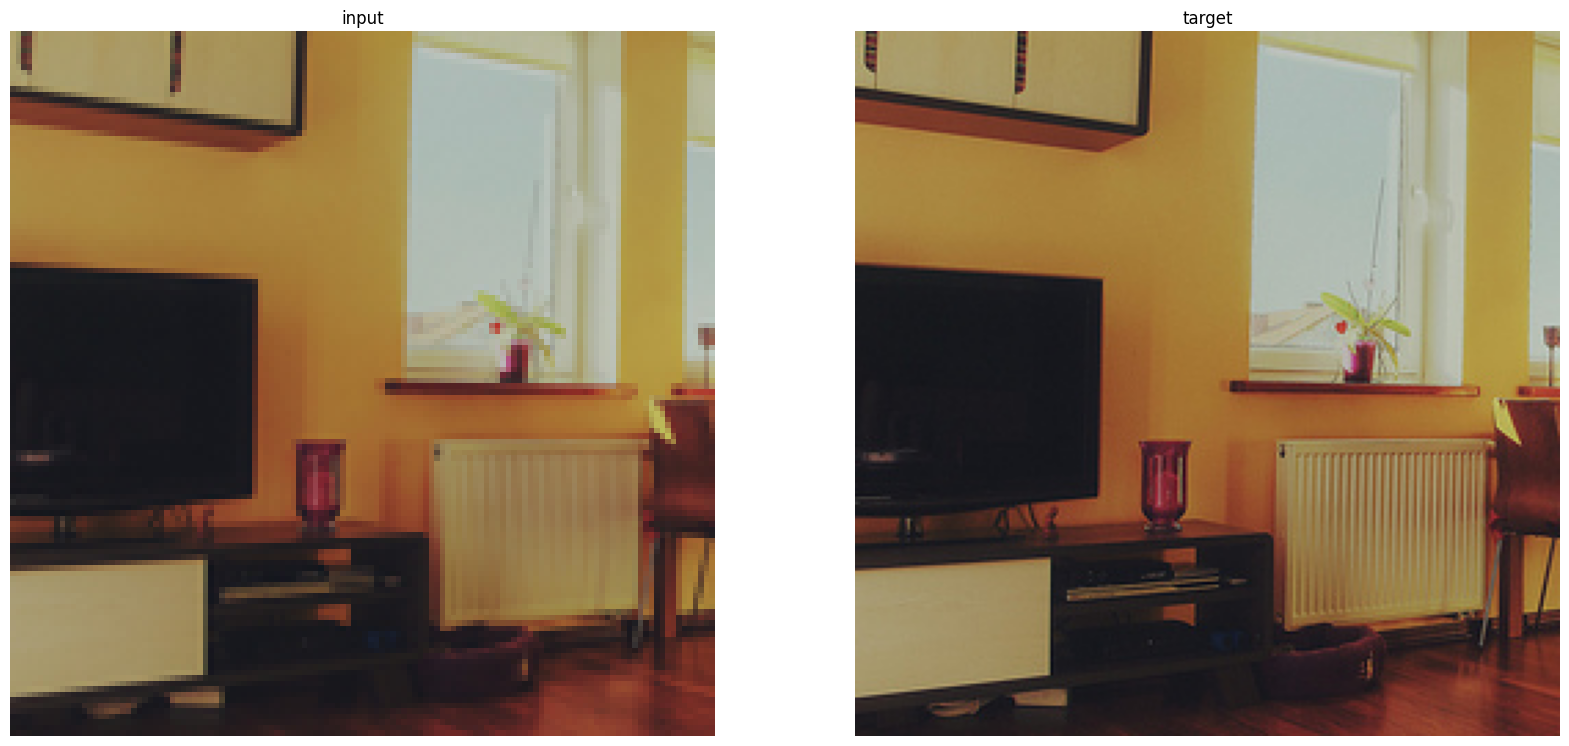

In [40]:
n = 0 

print(X[n].shape)

display_list = [np.array((X[n]+1)*127.5, dtype='int'),np.array((Y[n]+1)*127.5, dtype='int')]
title_list = ['input','target']
plt.figure(figsize = (20,20))

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(title_list[i])
    plt.imshow(display_list[i])
    plt.axis('off')

**CREATING GENERATOR MODEL**

* GAN uses two models, a generator model that generates output and a discriminator model that classifies wether the output is generated by the generator model(fake) or taken from the dataset(real)

* The generator model is a U-Net. It is a neural network used for image to image tasks. It has three major components : downsampling blocks, upsampling blocks and skip connections.

* Downsampling blocks convert image input to tensors of lower dimesions until it becomes a 1D tensor. Upsampling blocks convert output of downsampling blocks back to image output. Skip connections provide connections between downsampling and upsampling blocks at each level.

* Generator and discriminator compete against each other.

In [41]:
#downsampling block
#Structure : Conv2D -> BatchNorm -> LeakyReLU

def downsample(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0. , 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

#upsampling block
#Structure : Conv2DTranspose -> BatchNorm -> Dropout -> ReLU

def upsample(filters, size, apply_dropout = True):
    initializer = tf.random_normal_initializer(0. , 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result
    

In [42]:
def Generator():
    inputs = tf.keras.layers.Input(shape = [128,128,3])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm = False), #(bs,64,64,64)
        downsample(128, 4), #(bs,32,32,128)
        downsample(256, 4), #(bs,16,16,256)
        downsample(512, 4), #(bs,8,8,512)
        downsample(512, 4), #(bs,4,4,512)
        downsample(512, 4), #(bs,2,2,512)
        downsample(512, 4), #(bs,1,1,512)
    ] 
    #each downsampling reduces size by 2 because of stride = 2,
    #bs = batch size, 4th value is number of filters
    
    up_stack = [
        upsample(512, 4, apply_dropout = True), #(bs,2,2,1024)
        upsample(512, 4, apply_dropout = True), #(bs,4,4,1024)
        upsample(512, 4, apply_dropout = True), #(bs,8,8,1024)
        upsample(512, 4), #(bs,16,16,1024)
        upsample(256, 4), #(bs,32,32,512)
        upsample(128, 4), #(bs,64,64,256)
        
    ]
    
    initializer = tf.random_normal_initializer(0. , 0.02)
    last = tf.keras.layers.Conv2DTranspose(3,4,strides=4,padding='same',kernel_initializer = initializer,activation = 'tanh')#(bs,256,256,3)                                      
    
    x = inputs
    
    
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up,skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [43]:
generator = Generator()

if load_weights and weights_file_index != None:
    generator.load_weights(weights_folder + "generator_" + weights_file_index)
    
tf.keras.utils.plot_model(generator, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**GENERATOR LOSS**

* Generator loss consists of two components
* L1 loss which is mean absolute error between the generated image and target image to make generated images structurally similar to target images
* GAN loss which is binary crossentropy loss of discriminator's output on generated images and array of ones.
* Total loss = GAN loss + (LAMBDA * L1 loss)

In [44]:
LAMBDA = 500
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

**CREATING DISCRIMINATOR MODEL**

* Discriminator model is a PatchGAN
* In a PatchGAN, the output is a 3D vector referring to similarity between patches of input and target images
* Model consists of downsampling blocks : Conv->BatchNorm->LeakyReLU
* It receives two inputs : Input image and generated image which is classified as fake and input image and target image which is classified as real


In [45]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[128,128,3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256,256,3], name='target_image')
    
    inp_resized = tf.image.resize(inp, (256,256), method = 'bicubic')
    
    x = tf.keras.layers.concatenate([inp_resized,tar]) #(bs,256,256,6)
    x = downsample(64,4,False)(x) #(bs,128,128,64)
    x = downsample(128,4)(x) #(bs,64,64,128)
    x = downsample(256,4)(x) #(bs,32,32,256)
    
    x = tf.keras.layers.ZeroPadding2D()(x) #(bs,34,34,256)
    x = tf.keras.layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(x) #(bs,31,31,512)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.ZeroPadding2D()(x) #(bs,33,33,512)
    x = tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(x) #(bs,30,30,1)
    
    return tf.keras.Model(inputs = [inp,tar], outputs = x)

In [46]:
discriminator = Discriminator()

if load_weights and weights_file_index != None:
    discriminator.load_weights(weights_folder + "discriminator_" + weights_file_index)
    
tf.keras.utils.plot_model(discriminator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**DISCRIMINATOR LOSS**

* It takes two inputs : discriminator output for real images and generated images and it has two components : real loss and generated loss
* real loss is sigmoid cross entropy loss of real image output and array of ones
* generated loss is sigmoid cross entropy loss of generated image output and array of zeros
* total loss is sum of real loss and generated loss

In [47]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)
    
    return real_loss + gen_loss

**OPTIMIZERS AND CHECKPOINT SAVER**

In [48]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)


**FUNCTION TO GENERATE IMAGES**

In [49]:
def generate_images(model, inp, tar):
    inp_normalized = (inp/127.5)-1
    pred = model(inp_normalized, training = True)
    pred = (pred+1)*127.5
    
    #pred = Image.fromarray(tar[0].astype('uint8'),'RGB')
    display_list = [np.array(inp[0], dtype='int'),np.array(pred[0], dtype='int'),np.array(tar[0], dtype='int')]
    title_list = ['input','prediction','target']
    plt.figure(figsize = (20,20))
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    
    plt.show()




**TRAINING**

Epoch: 5 / 5 approximate duration(M): 9.946206970555563


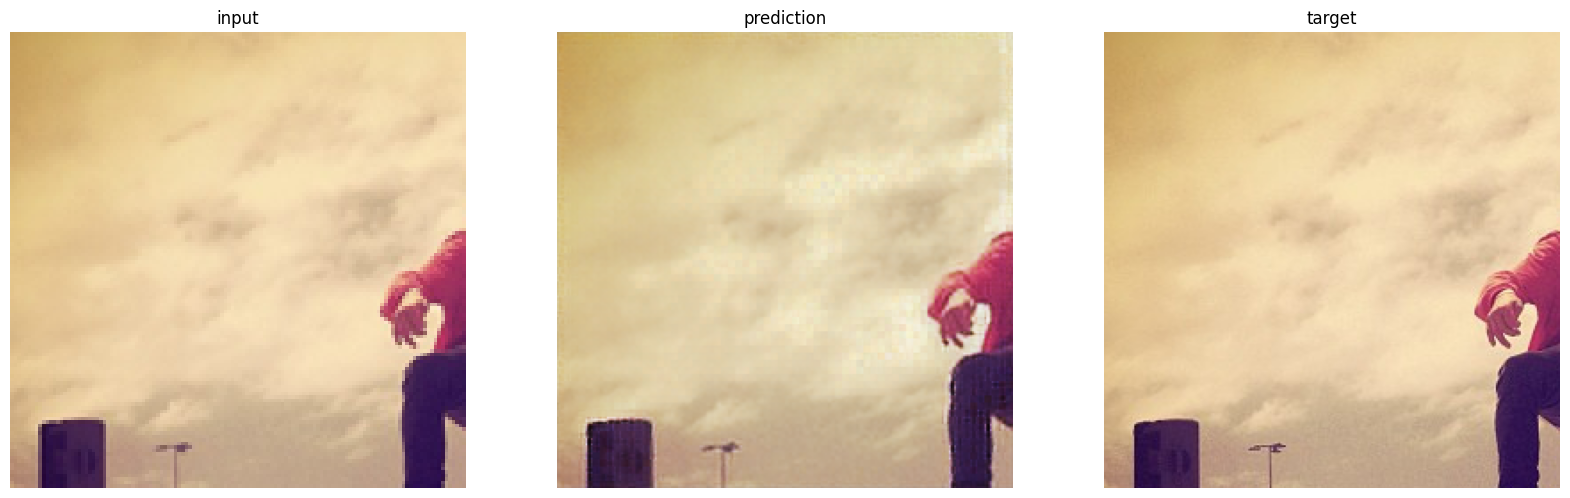

9773it [05:45, 28.28it/s]


In [50]:
EPOCHS = 5
@tf.function
def train_step(inp, tar, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(inp, training = True)
        
        disc_real_output = discriminator([inp,tar], training = True)
        disc_gen_output = discriminator([inp,gen_output], training = True)
        
        gen_loss = generator_loss(disc_gen_output, gen_output, tar)
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)
    
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

def fit(X_train, Y_train, X_test, Y_test, epochs):
    start = time.time()
    timer = 0
    for epoch in range(epochs):
        start = timeit.default_timer()
        clear_output(wait = True)
        if epoch != 0:
            timer = (epochs-epoch)*(timer/epoch)/60
            print("Epoch:", epoch+1,"/",EPOCHS, "approximate duration(M):", timer)
            
        generate_images(generator, (X_test[0]+1)*127.5, (Y_test[0]+1)*127.5)
        
        for inp,tar in tqdm(zip(X_train,Y_train)):
            train_step(inp,tar,epoch)
        
        if (epoch+1)%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        stop = timeit.default_timer()
        timer = time.time() - start
        
    checkpoint.save(file_prefix=checkpoint_prefix)

fit(X_train, Y_train, X_test, Y_test, EPOCHS)

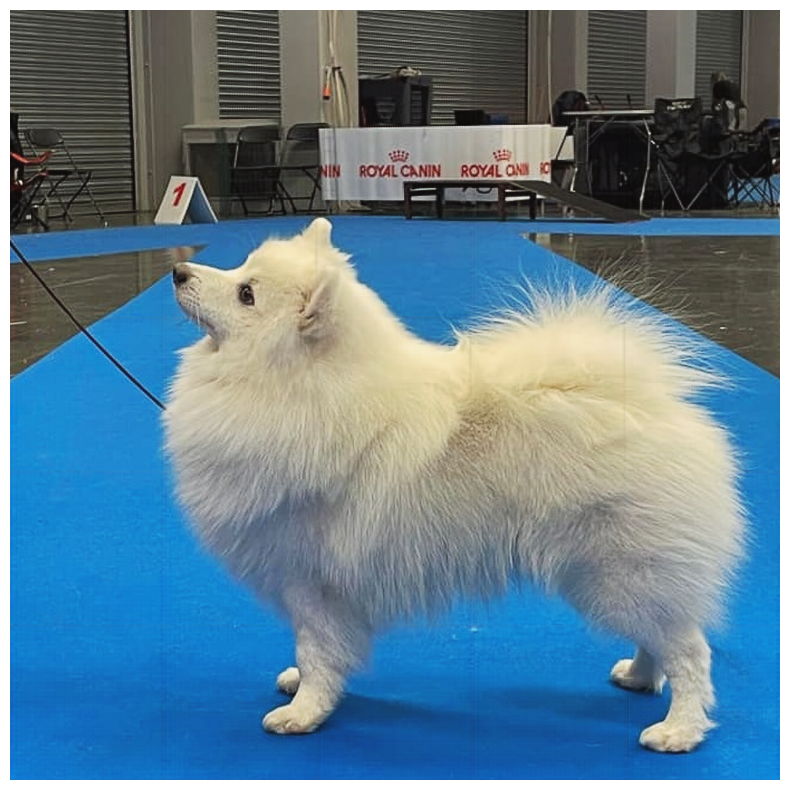

In [54]:
filename_target = r"C:\Users\common\Pictures\spitz\Prince FI 20230429 - Copy.jpg"
target_img = Image.open(filename_target)

parsed_img = parse(target_img, 128, with_map=True)
for i,piece in enumerate(parsed_img["img"]):
    piece = piece.reshape(-1,128,128,3)
    parsed_img["img"][i] = np.uint8((generator((piece/127.5)-1)+1)*127.5)
result = rebuild_img(parsed_img["img"], parsed_img["map"])
result = Image.fromarray(result)
plt.figure(figsize = (10,10))
plt.imshow(result)
plt.axis('off')
plt.show() 
name = r"C:\Users\common\Pictures\spitz\Prince_result.jpg"
result.save(name)

In [52]:
from datetime import datetime
now = datetime.now()

discriminator.save_weights(weights_folder + 'discriminator' + now.strftime("_%Y-%m-%d_%H"))
generator.save_weights(weights_folder + 'generator' + now.strftime("_%Y-%m-%d_%H"))

print("files:\n",
     'discriminator' + now.strftime("_%Y-%m-%d_%H"),"\n",
     'generator' + now.strftime("_%Y-%m-%d_%H"))


files:
 discriminator_2023-06-06_13 
 generator_2023-06-06_13
